# Entrenamiento de redes neuronales con PyTorch


## Funciones de costo y optimizadores

Para entrenar una red neuronal debemos definir 

1. Una función de costo: Aquello que vamos a minimizar
1. Un algoritmo de optimización: De que forma vamos a minimizar

Las funciones de costo están implementadas [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions) y las más comunes son:

| Problema | Recibe | Etiqueta | Función de costo | 
|----| ----| ---- | ---- |
|Regresión | Real | Real | `MSELoss` | 
|Clasificación | [0, 1] | {0, 1} | `BCELoss` | 
|Clasificación | Real | {0, 1} | `BCEWithLogitsLoss` |
|Clasificación (multiclase) | LogSoftmax | Entero |`LogLoss` |
|Clasificación (multiclase) | Real | Entero |`CrossEntropyLoss` |

:::{note}

`BCEWithLogitsLoss` y `CrossEntropyLoss` esperan que la salida de la red no tenga función de activación. Por el contrario `BCELoss` espera que la red tenga salida `Sigmoid`, mientras que `LogLoss` espera que tenga salida `LogSoftMax`. Las funciones de costo con logits son preferibles pues son más estables

:::


Luego de crear una instancia de estas clases las podemos llamar con una función. Por ejemplo si queremos calcular el error medio cuadrático entre dos tensores:

```python
criterion = torch.nn.MSELoss(reduction='mean')
loss = criterion(output, target)
```

:::{note}

También podemos crear nuestra propia función de costo. Por ejemplo podríamos lograr lo mismo que `MSELoss` habiendo definido `criterion = lambda ypred, y : (y-ypred).pow(2).mean()`

:::





Los algoritmos de optimización están implementados en el módulo [`torch.optim`](https://pytorch.org/docs/stable/optim.html?highlight=optim#module-torch.optim). Hoy en día los más utilizados son

| Optimizador | Descripción |
| ---- | ---- |
| `SGD` | Gradiente descedente estocástico con momentum|
| `Adam` | Gradiente descedente con tasa de aprendizaje adaptiva |


Para crear un objeto optimizar debemos entregar como argumento los parámetros del modelo y las argumetnos específicos del optimizar, por ejemplo para SGD:

```python
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0, weight_decay=0)
```

donde:

- `lr` Es la tasa de aprendizaje. Debe ser un valor pequeño para no desestabilizar el entrenamiento, pero no tan pequeño para enlentencerlo demasiado
- `momentum` es la tasa de momentum. Podemos utilizar un valor mayor que cero para evitar estancamiento en mínimos locales
- `weight_decay` controla la regularización (norma L2) de los parámetros. Podemos utilizar un valor mayor que cero para evitar sobreajuste 

Una vez creado podemos llamar su función principal `step()` la cual realiza una actualización de parámetros de acuerdo a las derivadas calculadas con `loss.backward()`

## Ajustando un modelo paso a paso

Consideremos el siguiente dataset $X$ con etiqueta $Y$, el cual deseamos clasificar con el modelo de la lección anterior:

In [1]:
import torch
import torch.nn as nn

X = torch.tensor([[-1.0, -1.0],
                  [-1.0, 1.0],
                  [1.0, -1.0],
                  [1.0, 1.0]])
Y = torch.tensor([[0.], [0.], [0.], [1.]])

model = nn.Sequential(nn.Linear(2, 2),
                      nn.Sigmoid(),
                      nn.Linear(2, 1))
model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
)

Dado que estamos en un escenario de clasificación binaria utilizaremos la entropía cruzada binaria como función de costo. Como optimizador utilizaremos el Adam

In [2]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

Realizamos una predicción (inferencia) con:

In [3]:
hatY = model(X)
hatY

tensor([[0.3936],
        [0.5618],
        [0.6491],
        [0.8052]], grad_fn=<AddmmBackward0>)

Calculamos la función de pérdida:

In [4]:
loss = criterion(hatY, Y)
loss

tensor(3.3611, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

Calcular el gradiente de la función de pérdida:

In [5]:
loss.backward()
model[0].weight.grad, model[0].bias.grad

(tensor([[-0.0729, -0.0951],
         [-0.1109, -0.1285]]),
 tensor([0.1762, 0.2132]))

In [6]:
model[2].weight.grad, model[2].bias.grad

(tensor([[0.7062, 0.5988]]), tensor([1.5819]))

Finalmente actualizamos los parámetros usando la función `step` de nuestro optimizador

In [7]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[0.3075, 0.7003],
         [0.6476, 0.0571]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3377, -0.1168], requires_grad=True))

In [8]:
optimizer.step()

In [9]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[0.3175, 0.7103],
         [0.6576, 0.0671]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3277, -0.1268], requires_grad=True))

Este proceso se realiza iterativamente durante un cierto número de pasos o "épocas" de entrenamiento

In [10]:
for nepoch in range(1000):
    hatY = model.forward(X)
    optimizer.zero_grad()
    loss = criterion(hatY, Y)
    loss.backward()
    optimizer.step()
    if nepoch % 100 == 0:
        print(f"{nepoch} {loss.item():0.2f} {torch.nn.Sigmoid()(hatY).detach().squeeze(1)}")

0 3.32 tensor([0.5915, 0.6317, 0.6515, 0.6863])
100 2.18 tensor([0.3343, 0.3641, 0.3803, 0.4299])
200 1.38 tensor([0.2106, 0.2883, 0.2962, 0.6383])
300 0.71 tensor([0.1286, 0.1733, 0.1777, 0.8263])
400 0.43 tensor([0.0850, 0.1096, 0.1120, 0.9025])
500 0.29 tensor([0.0606, 0.0758, 0.0773, 0.9363])
600 0.21 tensor([0.0456, 0.0559, 0.0570, 0.9545])
700 0.16 tensor([0.0358, 0.0432, 0.0440, 0.9655])
800 0.13 tensor([0.0289, 0.0345, 0.0351, 0.9728])
900 0.10 tensor([0.0239, 0.0282, 0.0287, 0.9780])


Paso a paso, el error (función de costo) disminuye y la predicción del modelo se acerca a la etiqueta:

In [11]:
Y.squeeze(1)

tensor([0., 0., 0., 1.])

## Entrenamiento por minibatches

Si el *dataset* del problema es de gran tamaño no es conveniente utilizar el conjunto completo para calcular la función de costo y derivar. 

En general actualizamos el modelo presentandole subconjuntos (*minibatches*) del dataset

:::{note}

Esto es lo que se conoce como la estimación estocástica del gradiente descedente (SGD)

:::

A continuación veremos algunas clases de PyTorch que facilitan la interacción entre el modelo y el conjunto de entrenamiento. A modo de ejemplo crearemos un conjunto de datos sintético con dos atributos, dos clases y que no es linealmente separable:

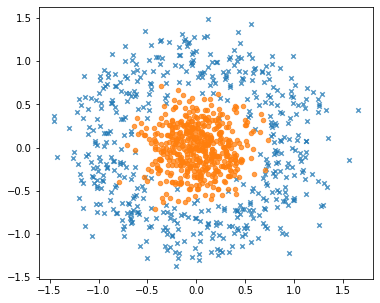

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

np.random.seed(0)
X, y = sklearn.datasets.make_circles(n_samples=1000, noise=0.2, factor=0.25)

fig, ax = plt.subplots(figsize=(6, 5))
for k, marker in enumerate(['x', 'o']):
    mask = y == k
    ax.scatter(X[mask, 0], X[mask, 1], s=20, marker=marker, alpha=0.75)

El súbmodulo [`torch.utils.data`](https://pytorch.org/docs/stable/data.html) tiene los objetos que facilitan la interacción con datos

Sus clases principales son 

- `Dataset`: Clase abstracta que representa a un conjunto de datos
- `Subset`: Clase que representa una partición de un conjunto de datos, por ejemplo la partición de entrenamiento o validación
- `DataLoader`: Generador que recibe un conjunto de datos y retorna subconjuntos (minibatches) iterativamente


El primer paso es crear una clase que represente nuestro conjunto de datos en particular, esta clase debe heredar de `Dataset` y debe implementar las funciones `__len__` y `__getitem__`

In [13]:
import torch.utils.data as data

class CircleDataset(data.Dataset):
    
    def __init__(self, data: np.ndarray, labels: np.ndarray):
        self.data = torch.from_numpy(data.astype('float32'))
        self.labels = torch.from_numpy(labels.astype('float32'))
        
    def __getitem__(self, idx: int):
        return (self.data[idx], self.labels[idx])
    
    def __len__(self):
        return len(self.labels)
    
    
dataset = CircleDataset(X, y)

dataset[0], len(dataset)

((tensor([0.3359, 0.0898]), tensor(1.)), 1000)

donde

- El constructor recibe los datos y los convierte en formato tensor
- `__getitem__`, recibe un índice y retorna una tupla (dato, etiqueta)
- `__len__` retorna la cantidad de ejemplos del conjunto de datos

Para crear una partición de este dataset utilizamos `Subset`, el cual recibe un objeto `Dataset` y una lista de índices. Utilizaremos las funciones de scikit-learn para obtener los índices


In [14]:
import sklearn.model_selection

train_idx, valid_idx = next(sklearn.model_selection.ShuffleSplit(train_size=0.6).split(X, y))
train_set = data.Subset(dataset, train_idx)
valid_set = data.Subset(dataset, valid_idx)

Finalmente creamos objetos `DataLoader` para obtener minibatches de entrenamiento y validación con:

In [15]:
train_loader = data.DataLoader(train_set, shuffle=True, batch_size=32)
valid_loader = data.DataLoader(valid_set, shuffle=False, batch_size=256)

Los argumentos principales de esta clase son:

- Un objeto `Dataset` o `Subset`
- `shuffle`: Booleano que índica si los ejemplos se muestran de forma ordenada o desordenada
- `batch_size`: Entero que indica la cantidad de ejemplos por *minibatch*

:::{important}

Es conveniente presentar el conjunto de entrenamiento en distinto orden en cada época. Utiliza `shuffle=True` para este conjunto. 

:::

Una vez creado el objeto `DataLoader` se puede ocupar de forma equivalente a otros iteradores de Python:

In [16]:
for batchx, batchy in train_loader:
    break
    
batchx.T, batchy

(tensor([[-1.7327e-01, -1.0192e+00,  4.0815e-01, -2.9667e-01,  2.1431e-01,
          -2.2319e-01, -1.3870e-01, -1.5043e-02, -3.7095e-01,  7.6336e-01,
          -9.6690e-02,  5.4272e-01, -7.1600e-01, -2.4498e-01,  3.9618e-01,
          -5.1439e-01,  6.4337e-04, -3.4907e-01, -5.3942e-01,  8.1837e-02,
          -1.6099e-01, -1.1824e+00,  1.0201e-01,  9.5019e-02, -2.4772e-01,
          -1.7803e-01, -7.9482e-02, -1.3004e+00,  4.6235e-01, -2.1174e-01,
           4.0220e-01, -2.6569e-01],
         [ 7.6027e-01,  2.5299e-02, -5.4140e-01, -1.1876e+00,  2.8078e-01,
           4.2319e-02,  7.7348e-02, -8.1583e-01, -1.3437e-01,  2.9762e-01,
          -1.0907e-01, -6.3094e-01, -2.2327e-01,  2.3199e-01, -2.7057e-01,
           2.2744e-01, -2.1625e-03,  1.0411e+00, -4.9032e-01,  9.0283e-02,
          -4.0258e-01,  4.8942e-01, -2.5249e-01, -1.5811e-01, -1.0133e+00,
           5.2976e-01,  4.1031e-01,  2.2441e-01,  8.0092e-01,  1.5784e-01,
           4.1156e-01, -3.1567e-01]]),
 tensor([0., 0., 1., 0.,

## Esquema general de entrenamiento en PyTorch

Habiendo definido el modelo, el criterio, el optimizador y los datos, el esquema general de entrenamiento de un modelo en PyTorch sería:

``` python
for epoch in range(num_epochs): # Durante un cierto número de épocas
    for minibatch in data: # Para cada minibatch de datos
        optimizer.zero_grad() # Limpiamos los gradientes
        x, y = minibatch # Desempaquetamos
        yhat = model.forward(x) # Predecimos
        loss = criterion(yhat, y) # Evaluamos
        loss.backward() # Calculamos los gradientes
        optimizer.step() # Actualizamos los parámetros
```

donde

- Una época es una presentación completa del conjunto de entrenamiento
- Un *minibatch* es un subconjunto del conjunto de entrenamiento


Adicionalmente, debemos considerar un bucle de validación donde sólo realizamos predicción y evaluación de la *loss* con el objetivo de detectar sobre-ajuste

Early Stopping
: Detención del entrenamiento cuando la loss de validación no haya disminuido durante una cierta cantidad de épocas (paciencia). Se utiliza para evitar el sobreajuste

:::{important}

En cada época, verifica que si el error de validación representa un nuevo mínimo. Si es así puedes respaldar el modelo utilizado [`torch.save`](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

:::

A continuaciones se ponen en práctica estos criterios utilizando PyTorch. Por conveniencia se implementan las siguientes funciones

- `update_step`: Recibe un minibatch  y actualiza los parámetros
- `evaluation_step`: Recibe un minibtach y evalúa el criterio de optimización
- `train_one_epoch`: Realiza una época de entrenamiento. Se encarga de guardar el modelo si es el mejor encontrado hasta ese punto


In [17]:
def update_step(data, label):
    prediction = model(data)
    optimizer.zero_grad()
    loss = criterion(prediction, label.unsqueeze(1))
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_step(data, label):
    prediction = model(data)
    loss = criterion(prediction, label.unsqueeze(1))
    return loss.item()

def train_one_epoch(epoch):    
    train_loss, valid_loss = 0.0, 0.0    
    for batchx, batchy in train_loader:
        train_loss += update_step(batchx, batchy)    
    for batchx, batchy in valid_loader:
        valid_loss += evaluate_step(batchx, batchy)
        
    # Guardar modelo si es el mejor hasta ahora
    global best_valid_loss
    if epoch % 10 == 0:
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({'epoca': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': valid_loss}, 
                       'best_model.pt')
    
    return train_loss/len(train_loader.dataset), valid_loss/len(valid_loader.dataset)

En este caso el modelo se entrena por 500 épocas

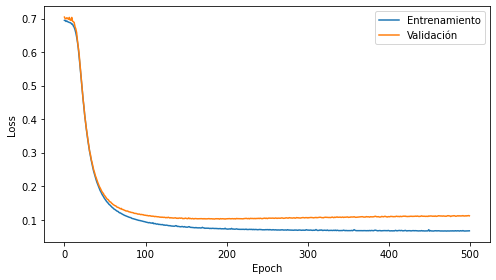

In [18]:
def circle_model(n_hidden: int):
    return nn.Sequential(nn.Linear(2, n_hidden), nn.Sigmoid(), nn.Linear(n_hidden, 1))

model = circle_model(10)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

max_epochs, best_valid_loss = 500, np.inf
running_loss = np.zeros(shape=(max_epochs, 2))

for epoch in range(max_epochs):
    running_loss[epoch] = train_one_epoch(epoch)
    
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:, 0], label='Entrenamiento')
ax.plot(running_loss[:, 1], label='Validación')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend();

Cargamos la información serializada del modelo utilizado `torch.load`

In [19]:
saved_model = torch.load('best_model.pt')

El mejor modelo se obtuvo en la época

In [20]:
saved_model['epoca']

220

Podemos asignar los mejores parámetros al modelo anterior con:

In [21]:
model = circle_model(10)
model.load_state_dict(saved_model['model_state_dict'])

<All keys matched successfully>

El resultado de predicción en el espacio de características del mejor modelo es:

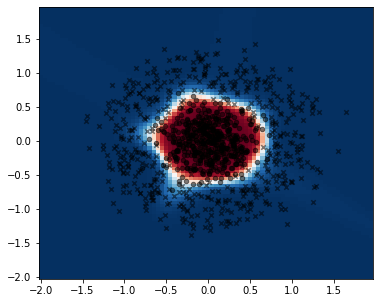

In [22]:
x_test = np.arange(-2, 2, 0.05, dtype=np.float32)
x_test1, x_test2 = np.meshgrid(x_test, x_test)
x_test = torch.from_numpy(np.stack((x_test1.ravel(), x_test2.ravel())).T)

prob_test = nn.Sigmoid()(model(x_test)).detach().reshape(x_test1.shape)

fig, ax = plt.subplots(figsize=(6, 5))
ax.pcolormesh(x_test1, x_test2, prob_test, cmap=plt.cm.RdBu_r)
for k, marker in enumerate(['x', 'o']):
    mask = y == k
    ax.scatter(X[mask, 0], X[mask, 1], c='k', s=20, marker=marker, alpha=0.5)

El resultado en la capa de salida tiene forma circular. Inspeccionemos la salida de la capa oculta, que en este caso tiene 10 neuronas:

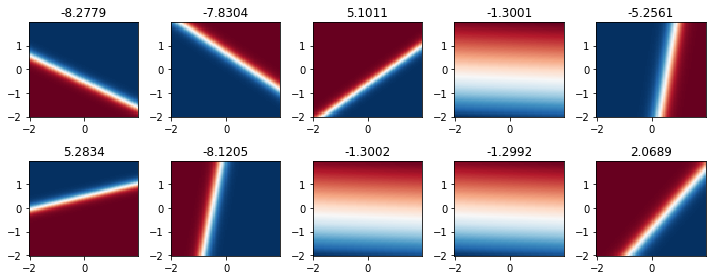

In [23]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4), tight_layout=True)

for ax_, layer, w in zip(ax.ravel(), model[0](x_test).T, model[2].weight.detach()[0]):
    ax_.pcolormesh(x_test1, x_test2, 
                   nn.Sigmoid()(layer).reshape(x_test1.shape).detach(), 
                   cmap=plt.cm.RdBu_r)
    ax_.set_title(f"{w.item():0.4f}")


:::{note}

La capa de salida combina los hiperplanos de la capa oculta para formar un circulo. Sobre cada salida se muestra su peso en la capa de salida

:::

## Diagnósticos a partir de curvas de aprendizaje

Podemos diagnosticar el entrenamiento observando la evolución de la función de costo 

:::{important}

Siempre visualiza la loss en ambos conjuntos: entrenamiento y validación

:::

Veamos algunos casos

**Ambas curvas en descenso**

Si las curvas se ven así:

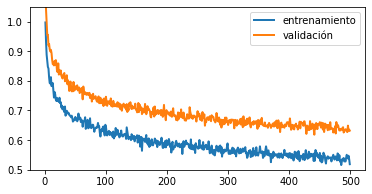

In [24]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs)) + 0.1
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

En este caso deberías continuar con el entrenamiento, pues no hay señal de convergencia

**Sobreajuste temprano**

Si las curvas se ven así:

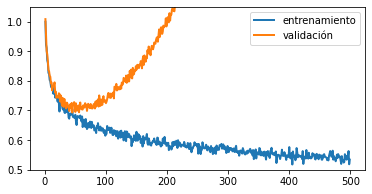

In [25]:
epochs = np.arange(1, 500)
loss_train = (epochs)**(-1/10) + 0.01*np.random.randn(len(epochs))
loss_valid = (epochs)**(-1/10) + 0.00001*(epochs)**2 +0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
ax.set_ylim([0.5, 1.05])
plt.legend();

Significa que tu modelo se ha sobreajustado, por ende:

- Implementa un modelo más sencillo
- Consigue más datos
- Considera utilizar regularización 

**Error en el código o mal punto de partida**

Si tus curvas se ven así:

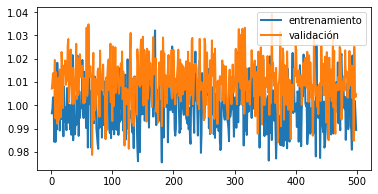

In [26]:
epochs = np.arange(1, 500)
loss_train = 1.0 + 0.01*np.random.randn(len(epochs))
loss_valid = 1.0 + 0.01*np.random.randn(len(epochs)) + 0.01
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(epochs, loss_train, lw=2, label='entrenamiento')
ax.plot(epochs, loss_valid, lw=2, label='validación')
#ax.set_ylim([0.5, 1.05])
plt.legend();

Revisa que tu código no tenga bugs, en particular que el modelo no esté retornando `nans`, que la función de costo sea adecuada para el problema y que la taza de aprendizaje no sea demasiado alta

También puede deberse a una muy mala inicialización aleatoria, reinicia el entrenamiento para comprobar si es el caso